# House Prices - Advanced Regression Techniques: Predict sales prices and practice feature engineering, RFs, and gradient boosting

# 1. Data Exploration and Preprocessing

## Load and Exploring the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df1 = pd.read_csv('data_downloaded/train.csv')

## Handling Missing Values

In [4]:
replacement_dictionary = {
                            'PoolQC'      : 'No Pool',
                            'MiscFeature' : 'No MiscFeatures',  
                            'Alley'       : 'No Alley Access',
                            'Fence'       : 'No Fence',
                            'FireplaceQu' : 'No FirePlace', 
                            'GarageFinish': 'No Garage',
                            'GarageQual'  : 'No Garage',
                            'GarageCond'  : 'No Garage',
                            'GarageType'  : 'No Garage',
                            'BsmtExposure': 'No Basement',
                            'BsmtCond'    : 'No Basement',
                            'BsmtQual'    : 'No Basement',
                            'BsmtFinType2': 'No Basement',
                            'BsmtFinType1': 'No Basement',
                            'Electrical'  : 'No Electrical',
                            'MasVnrType'  : 'No MasVnr',
                            'MasVnrArea'  : 0,
                            'LotFrontage' : 0,
                            'GarageYrBlt' : 0}

In [5]:
from data_downloaded.fatih_missing_values import Dealing_missing_values

In [6]:
missing_handler = Dealing_missing_values(df1)

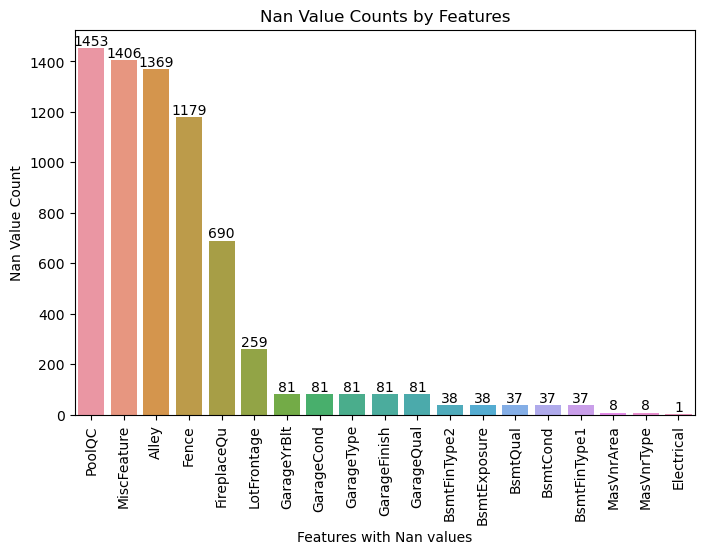

In [7]:
missing_handler.show_missing_values()

In [8]:
missing_handler.replace(replacement_dictionary)

In [9]:
missing_handler.show_missing_values()

There are no missing values


In [10]:
df2 = df1.copy()

In [11]:
df2.shape

(1460, 81)

## Feature Engineering

### Summarizing Features: Creating new Features and drop old ones

In [12]:
# Hold 'GrLivArea' / drop '1stFlrSF', '2ndFlrSF'

# Hold 'TotRmsAbvGrd' / drop 'BedroomAbvGr'

# Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
df2['Total_Bathrooms'] = df2['BsmtFullBath'] + df2['FullBath'] + 0.5*(df2['BsmtHalfBath'] + df2['HalfBath'])

# Create Age of the House / drop 'YearBuilt'
df2['Age_of_Property'] = df2['YearBuilt'].max() - df2['YearBuilt']

# Create 'Age_of_Renovation' / drop 'YearRemodAdd'
df2['Age_of_Renovation'] = df2['YearBuilt'].max() - df2['YearRemodAdd']

# Hold 'GarageArea', create 'Has_Garage' binary / drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
df2['HasGarage'] = (df2['GarageType'] != 'No Garage').astype(int)

In [13]:
# Create 'Neibhborhood_MedianP' / drop 'Neighborhood'
neighborhood_median_price = df2.groupby('Neighborhood')['SalePrice'].median().reset_index()
neighborhood_median_price.columns = ['Neighborhood', 'MedianHousePrice']
df2 = pd.merge(df2, neighborhood_median_price, on='Neighborhood', how='left')

In [14]:
# Define different mappings for each basement features (because we will make math operations/grading)
bsmt_qual_mapping = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'No Basement': 0}
bsmt_cond_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0}
bsmt_exposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'No Basement': 0}
bsmt_fintype_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0}

# Convert the categorical str values into grade points by mapping function
df2['BsmtFinType1'] = df2['BsmtFinType1'].map(bsmt_fintype_mapping)
df2['BsmtFinType2'] = df2['BsmtFinType2'].map(bsmt_fintype_mapping)
df2['BsmtQual'] = df2['BsmtQual'].map(bsmt_qual_mapping)
df2['BsmtCond'] = df2['BsmtCond'].map(bsmt_cond_mapping)
df2['BsmtExposure'] = df2['BsmtExposure'].map(bsmt_exposure_mapping)

# FinType has a numeric grade and a corresponding sqfoot, combine them
df2['BsmtFinGrade'] = (df2['BsmtFinType1'] * df2.BsmtFinSF1 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType2'] * df2.BsmtFinSF2 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType1'] * df2.BsmtUnfSF / df2.TotalBsmtSF)

# Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
df2['BsmtFinGrade'].fillna(0.0, inplace=True)

# Combine into one single 'BsmtOverallGrade'
df2['BsmtOverallGrade'] = round((df2['BsmtQual'] + df2['BsmtCond'] + df2['BsmtExposure'] + df2['BsmtFinGrade']), 2)

# Drop :
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
# 'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade'

In [15]:
# Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
terrace_weights = [1, 1, 2, 2, 2]

df2['Terrace_Grade'] = np.dot(df2[terrace_columns], terrace_weights)

__Dropping the columns__

In [16]:
col_drop_feat_eng = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
                     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'YearBuilt', 'YearRemodAdd', 
                    'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond',
                    'Neighborhood', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
                    'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade',
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [17]:
df3 = df2.drop(columns=col_drop_feat_eng)
df3.shape

(1460, 59)

In [18]:
df3.sample(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
987,988,20,RL,83.0,10159,Pave,No Alley Access,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,1Story,9,5,Hip,CompShg,VinylSd,VinylSd,Stone,450.0,Ex,TA,PConc,1930,GasA,Ex,Y,SBrkr,0,1940,1,Ex,8,Typ,1,Gd,606,Y,0,No Pool,No Fence,No MiscFeatures,0,4,2010,New,Partial,395192,3.5,1,0,1,315000.0,17.0,263
691,692,60,RL,104.0,21535,Pave,No Alley Access,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,2Story,10,6,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,2444,GasA,Ex,Y,SBrkr,0,4316,1,Ex,10,Typ,2,Ex,832,Y,0,No Pool,No Fence,No MiscFeatures,0,1,2007,WD,Normal,755000,4.0,16,15,1,301500.0,18.0,432


### High and Low Cardinality

Cardinality is an issue for categorical variables. But our df has some cat vars in numerical vars as well 

In [19]:
from data_downloaded.fatih_eda import plot_histograms_for_all_numeric, plot_barplot_all_categoric

In [20]:
cat_feat_check_cardinality = ['Id', 'KitchenAbvGr', 'HasGarage', 'Street', 'Alley', 'Utilities', 
                              'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'Heating', 'CentralAir', 
                              'Electrical', 'Functional', 'PavedDrive', 'PoolQC', 'MiscFeature', 'SaleType', 'SaleCondition'  ]
cont_feat_check_cardinalty = ['LowQualFinSF', 'PoolArea', 'MiscVal' ]

In [21]:
# I can Check the correlations of suspicious low-varied features with Target, if low i can drop them
cardinality_drop_columns = []
for col in cont_feat_check_cardinalty:
    coref = df3[col].corr(df3['SalePrice'])
    if abs(coref) < 0.1:
        cardinality_drop_columns.append(col)
        print(f"Correlation of {col} with Sale Price is {coref}")
    
# drop 'LowQualFinSF', 'PoolArea', 'MiscVal'

Correlation of LowQualFinSF with Sale Price is -0.02560613000067956
Correlation of PoolArea with Sale Price is 0.09240354949187322
Correlation of MiscVal with Sale Price is -0.02118957964030325


In [22]:
# I can check value_counts % of categorical and so called categorical variables

for col in cat_feat_check_cardinality:
    vc_df = df3[col].value_counts(normalize=True).sort_values(ascending=False).reset_index()
    freq = round(vc_df.iloc[0,1], 3)
    value = vc_df.iloc[0,0]
    if (freq > 0.95) or (freq < 0.03):
        cardinality_drop_columns.append(col)
        print(f"{col.ljust(15)} -- {str(value).ljust(15)} -- {freq}")

Id              -- 1               -- 0.001
KitchenAbvGr    -- 1               -- 0.953
Street          -- Pave            -- 0.996
Utilities       -- AllPub          -- 0.999
Condition2      -- Norm            -- 0.99
RoofMatl        -- CompShg         -- 0.982
Heating         -- GasA            -- 0.978
PoolQC          -- No Pool         -- 0.995
MiscFeature     -- No MiscFeatures -- 0.963


In [23]:
cardinality_drop_columns

['LowQualFinSF',
 'PoolArea',
 'MiscVal',
 'Id',
 'KitchenAbvGr',
 'Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'PoolQC',
 'MiscFeature']

In [24]:
df4 = df3.drop(columns=cardinality_drop_columns)

In [25]:
print(df3.shape, '--->', df4.shape)

(1460, 59) ---> (1460, 47)


## Outliers

In [26]:
from data_downloaded.fatih_eda import FatihOutliers

In [27]:
outliers = FatihOutliers(df4)

In [28]:
o1 = outliers.show_outliers_for_features('LotFrontage')
o1

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
934,20,RL,313.0,27650,No Alley Access,IR2,HLS,Inside,Mod,PosA,1Fam,1Story,7,7,Flat,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,585,Ex,Y,SBrkr,2069,Gd,9,Typ,1,Gd,505,Y,No Fence,11,2008,WD,Normal,242000,3.0,50,3,1,140000.0,17.0,0
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,Ex,12,Typ,3,Gd,1418,Y,No Fence,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [29]:
o2 = outliers.show_outliers_for_features('MasVnrArea').sort_values(by='MasVnrArea', ascending=False).head(2)
o2

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
297,60,FV,66.0,7399,Pave,IR1,Lvl,Inside,Gtl,Norm,1Fam,2Story,7,5,Hip,VinylSd,VinylSd,BrkFace,1600.0,Gd,TA,PConc,975,Ex,Y,SBrkr,1950,Gd,7,Typ,1,TA,576,Y,No Fence,6,2007,WD,Normal,239000,2.5,13,12,1,225500.0,12.0,406
1169,60,RL,118.0,35760,No Alley Access,IR1,Lvl,CulDSac,Gtl,Norm,1Fam,2Story,10,5,Hip,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,1930,Ex,Y,SBrkr,3627,Gd,10,Typ,1,TA,807,Y,No Fence,7,2006,WD,Normal,625000,4.5,15,14,1,301500.0,18.0,437


In [30]:
o3 = outliers.show_outliers_for_features('TotalBsmtSF').sort_values(by='TotalBsmtSF', ascending=False).head(1)
o3

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,Ex,12,Typ,3,Gd,1418,Y,No Fence,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [31]:
o4 = outliers.show_outliers_for_features('GrLivArea')
o4

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
523,60,RL,130.0,40094,No Alley Access,IR1,Bnk,Inside,Gtl,PosN,1Fam,2Story,10,5,Hip,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,3138,Ex,Y,SBrkr,4676,Ex,11,Typ,1,Gd,884,Y,No Fence,10,2007,New,Partial,184750,4.5,3,2,1,121750.0,18.0,614
691,60,RL,104.0,21535,No Alley Access,IR1,Lvl,Corner,Gtl,Norm,1Fam,2Story,10,6,Gable,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,2444,Ex,Y,SBrkr,4316,Ex,10,Typ,2,Ex,832,Y,No Fence,1,2007,WD,Normal,755000,4.0,16,15,1,301500.0,18.0,432
1182,60,RL,160.0,15623,No Alley Access,IR1,Lvl,Corner,Gtl,Norm,1Fam,2Story,10,5,Hip,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,2396,Ex,Y,SBrkr,4476,Ex,10,Typ,2,TA,813,Y,MnPrv,7,2007,WD,Abnorml,745000,4.5,14,14,1,301500.0,17.0,249
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,Ex,12,Typ,3,Gd,1418,Y,No Fence,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [32]:
o5 = outliers.show_outliers_for_features('TotRmsAbvGrd')
o5

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
635,190,RH,60.0,10896,Pave,Reg,Bnk,Inside,Gtl,Feedr,2fmCon,2.5Fin,6,7,Hip,VinylSd,VinylSd,None,0.0,Fa,TA,CBlock,1440,Ex,Y,FuseA,3395,Fa,14,Typ,0,No FirePlace,0,N,No Fence,3,2007,WD,Abnorml,200000,2.0,96,15,0,139500.0,8.0,110


In [33]:
o6 = outliers.show_outliers_for_features('Terrace_Grade')
o6

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1328,50,RM,60.0,10440,Grvl,Reg,Lvl,Corner,Gtl,Norm,1Fam,1.5Fin,6,7,Gable,BrkFace,Wd Sdng,None,0.0,Gd,Gd,BrkTil,1510,Ex,Y,SBrkr,2792,TA,8,Mod,2,TA,520,Y,MnPrv,6,2008,WD,Normal,256000,2.0,90,60,1,119000.0,10.0,1507


In [34]:
outliers_index_drop = list(set(list(o1.index) + list(o2.index) + list(o3.index) + list(o4.index) + list(o5.index) + list(o6.index)))
outliers_index_drop

[934, 297, 523, 1328, 1169, 1298, 691, 635, 1182]

In [35]:
df5 = df4.drop(index=outliers_index_drop)

In [36]:
print(df4.shape, ' ---> ', df5.shape)

(1460, 47)  --->  (1451, 47)


# Exploratory Data Analysis

## Exploring The Relationships with Target

### Numeric Variables

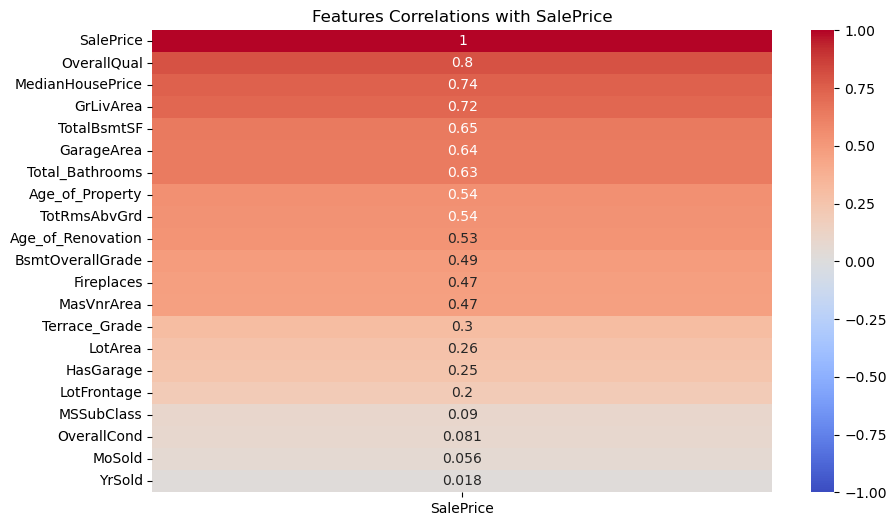

In [37]:
target_column = 'SalePrice'
corr_matrix = df5.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title(f'Features Correlations with {target_column}')
plt.show()

In [41]:
features_drop_low_correlation_numeric = []
for i,v in corr_with_target.iteritems():
    if (abs(v) < 0.2):
        features_drop_low_correlation_numeric.append(i)
features_drop_low_correlation_numeric

['LotFrontage', 'MSSubClass', 'OverallCond', 'MoSold', 'YrSold']

In [43]:
df6 = df5.drop(columns=features_drop_low_correlation_numeric)
print(df5.shape, ' ---> ', df6.shape)

(1451, 47)  --->  (1451, 42)


### Categorical Variables

**ANOVA & Boxplots**

In [44]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [45]:
categorical_columns = df6.select_dtypes(include='object').columns
drop_col_for_ANOVA = []
p_values_ANOVA = {}
for col in categorical_columns:
    str_ANOVA_item = 'SalePrice' + ' ~ C(' + col + ')'
    model = ols( str_ANOVA_item , data=df6).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = (anova_table['PR(>F)'][0])
    p_values_ANOVA[col] = p_value

for i,v in p_values_ANOVA.items():
    if v>0.05:
        drop_col_for_ANOVA.append(i)
        print(i, v)
drop_col_for_ANOVA

LandSlope 0.1013708113484022


['LandSlope']

In [46]:
df7 = df6.drop(columns=drop_col_for_ANOVA)
print(df6.shape, ' ---> ', df7.shape)

(1451, 42)  --->  (1451, 41)


**I checked ANOVA scores and only 'LandSlope' will be dropped, and nothing else understood**  
**I also checked boxplots but nothing significant came**  
**Now i will try encoding and then check correlations with TARGET**

In [47]:
df7.sample(3)

,MSZoning,LotArea,Alley,LotShape,LandContour,LotConfig,Condition1,BldgType,HouseStyle,OverallQual,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
325,RM,5000,No Alley Access,Reg,Lvl,Inside,RRAe,1Fam,1.5Unf,5,Gable,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,720,Po,N,FuseF,803,TA,5,Typ,0,No FirePlace,360,Y,No Fence,WD,Normal,87000,1.0,69,60,1,103000.0,13.0,488
987,RL,10159,No Alley Access,IR1,Lvl,Inside,Norm,1Fam,1Story,9,Hip,VinylSd,VinylSd,Stone,450.0,Ex,TA,PConc,1930,Ex,Y,SBrkr,1940,Ex,8,Typ,1,Gd,606,Y,No Fence,New,Partial,395192,3.5,1,0,1,315000.0,17.0,263
927,RL,9900,No Alley Access,Reg,Lvl,Inside,Feedr,1Fam,2Story,7,Gable,MetalSd,MetalSd,BrkFace,342.0,TA,TA,CBlock,832,Gd,Y,SBrkr,1978,TA,9,Typ,1,Gd,486,Y,GdPrv,WD,Normal,176000,2.5,42,42,1,182900.0,11.0,43


In [48]:
categorical_columns = df7.select_dtypes(include='object').columns
categorical_columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [49]:
df_encoded_temporary = pd.get_dummies(df7[categorical_columns], drop_first=True)

In [50]:
df_encoded_temporary['SalePrice'] = df7['SalePrice']
target_column = 'SalePrice'
corr_matrix = df_encoded_temporary.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)

corr_with_target.nlargest(20)

SalePrice                   1.000000
ExterQual_TA                0.601943
KitchenQual_TA              0.532142
Foundation_PConc            0.509228
FireplaceQu_No FirePlace    0.482039
ExterQual_Gd                0.466373
MasVnrType_None             0.388465
SaleType_New                0.383844
SaleCondition_Partial       0.378062
FireplaceQu_Gd              0.366363
MasVnrType_Stone            0.355214
Foundation_CBlock           0.348790
KitchenQual_Gd              0.341609
Exterior2nd_VinylSd         0.332905
Exterior1st_VinylSd         0.331657
HeatingQC_TA                0.318373
MSZoning_RM                 0.298427
LotShape_Reg                0.262835
SaleType_WD                 0.262797
CentralAir_Y                0.259747
Name: SalePrice, dtype: float64

In [51]:
corr_of_categoric_columns = {}
for col in categorical_columns:
    corr_of_categoric_columns[col] = []
    vc = df7[col].value_counts(normalize=True)
    
    #iterate through corr matrix index and values
    for i,v in corr_with_target.items():
        c_sc = i.split('_')
        if col == c_sc[0]:
            
            #find the weight of sub-categories depending on frequncy
            weight = vc[c_sc[1]]
            corr_for_sub_cateory = v * weight
            corr_of_categoric_columns[col].append(corr_for_sub_cateory)
            
corr_of_categoric_columns = {key: sum(value) for key, value in corr_of_categoric_columns.items()}
corr_of_categoric_columns_df = pd.DataFrame(list(corr_of_categoric_columns.items()), columns=['Categorical Feature', 'Correlation with SalePrice'])
corr_of_categoric_columns_df.sort_values(by='Correlation with SalePrice', ascending=False)

,Categorical Feature,Correlation with SalePrice
12,ExterQual,0.532128
18,KitchenQual,0.410782
14,Foundation,0.378980
20,FireplaceQu,0.358810
11,MasVnrType,0.321795
23,SaleType,0.260559
0,MSZoning,0.249689
16,CentralAir,0.242741
17,Electrical,0.231677
21,PavedDrive,0.222591


In [53]:
features_drop_low_correlation_categoric = corr_of_categoric_columns_df[corr_of_categoric_columns_df['Correlation with SalePrice']<0.20] \
                                         ['Categorical Feature'].to_list()

In [55]:
features_drop_low_correlation_categoric

['Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'ExterCond',
 'HeatingQC',
 'Functional',
 'Fence',
 'SaleCondition']

In [56]:
df8 = df7.drop(columns=features_drop_low_correlation_categoric)
print(df7.shape, ' ---> ', df8.shape)


(1451, 41)  --->  (1451, 27)


## Relationships Among Independent Variables

### Numeric Variables

**Correlations and Eigenvalues**
Note: Compute the eigenvalues of the correlation matrix. If there are one or more eigenvalues that are close to zero, it suggests the presence of multicollinearity.

**Variance Inflation Factor (VIF)**

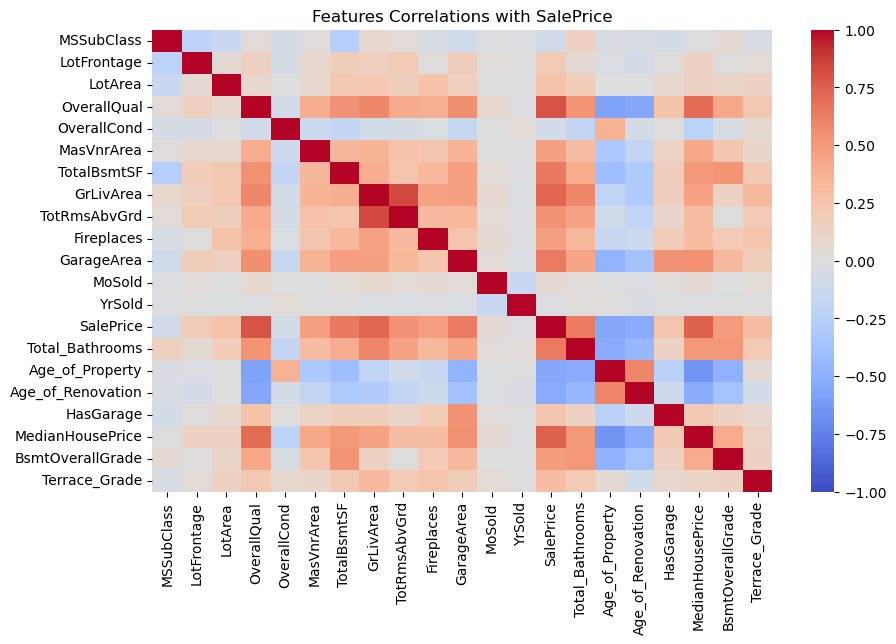

In [93]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title(f'Features Correlations with {target_column}')
plt.show()

### Categorical Variables

**Variance Inflation Factor (VIF)**

**Cramers V**

**Correlations**

## Observing Distributions and Skewnesses

kategorikler icin de bakmali miyim

# Encode categorical variables

### Nominal Categories

In [125]:
nominal_categorical_vars = ['MSZoning',  'LotConfig', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'MasVnrType', 
                            'Exterior1st','Exterior2nd', 'Foundation', 'Electrical', 'SaleType', 'SaleCondition']


ordinal_categorical_vars = ['Alley', 'LotShape', 'LandContour', 'ExterQual', 'ExterCond','HeatingQC',
                           'KitchenQual', 'Functional', 'FireplaceQu', 'PavedDrive', 'Fence', ]

binary_categorical_vars = ['CentralAir']

In [95]:
nominal_categories = ['MSZoning', 'Condition1', 'HouseStyle', 'SaleCondition']

In [96]:
df_encoded = pd.get_dummies(df10[nominal_categories], columns=nominal_categories)

In [97]:
df10.drop(columns=nominal_categories, inplace=True)

In [98]:
df11 = pd.concat([df10, df_encoded], axis=1)

In [99]:
df11.shape

(1408, 45)

### Ordinal Categories

In [100]:
ordinal_categories = ['ExterCond',	'KitchenQual']

In [101]:
ordinal_mapping = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}

In [102]:
df11['ExterCond'] = df11['ExterCond'].map(ordinal_mapping)

In [103]:
df11['KitchenQual'] = df11['KitchenQual'].map(ordinal_mapping)

In [104]:
df11.sample(3)

,BsmtOverallGrade,Terrace_Grade,ExterCond,KitchenQual,OverallQual,OverallCond,LotArea,Total_Area,Total_Bathrooms,GarageArea,...,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
684,9.0,81,3,3,7,5,16770,3034,2.5,486,...,0,1,0,0,0,0,0,0,1,0
359,16.0,1031,3,4,8,5,12011,3010,3.5,592,...,0,1,0,0,0,0,0,0,1,0
982,11.0,116,3,4,7,5,3182,2532,2.0,388,...,0,0,0,0,0,0,0,0,1,0


In [11]:
#denme

__V2: log transformation here__

In [105]:
y = np.log(df11['SalePrice'])
df12 = df11.drop(columns=['SalePrice', 'HouseStyle_2.5Fin'])

In [106]:
X=df12.copy()

In [107]:
X.head()

,BsmtOverallGrade,Terrace_Grade,ExterCond,KitchenQual,OverallQual,OverallCond,LotArea,Total_Area,Total_Bathrooms,GarageArea,...,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,14.0,61,3,4,7,5,8450,2566,3.5,548,...,0,1,0,0,0,0,0,0,1,0
1,16.0,298,3,3,6,8,9600,2524,2.5,460,...,0,0,0,0,0,0,0,0,1,0
2,15.0,42,3,4,7,5,11250,2706,3.5,608,...,0,1,0,0,0,0,0,0,1,0
3,13.0,579,3,4,7,5,9550,2473,2.0,642,...,0,1,0,0,1,0,0,0,0,0
4,16.0,276,3,4,8,5,14260,3343,3.5,836,...,0,1,0,0,0,0,0,0,1,0


# Prepare Test Data

In [108]:
df_test = pd.read_csv('data_downloaded/test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [109]:
missing_handler_test = Dealing_missing_values(df_test)

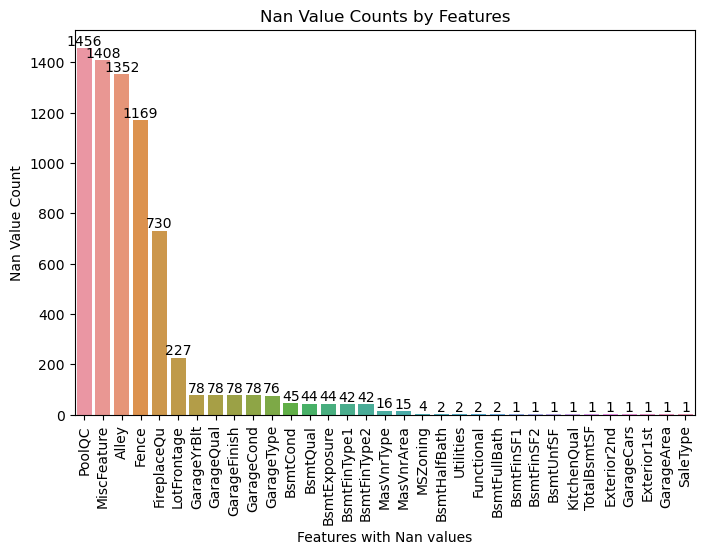

In [110]:
missing_handler_test.show_missing_values()

In [111]:
missing_handler_test.replace(replacement_dictionary)

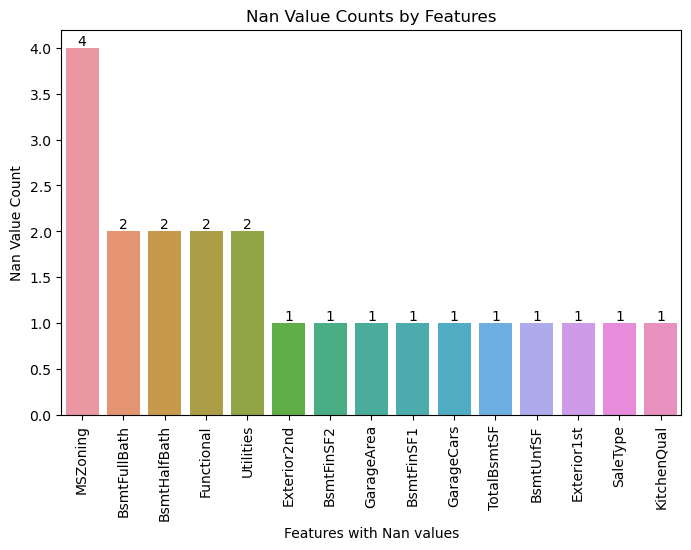

In [112]:
missing_handler_test.show_missing_values()

In [113]:
missing_handler_test.mmm(['MSZoning', 'Functional', 'Utilities', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual'], 'mode')

In [114]:
replacement_dictionary_test = {'BsmtFullBath':0, 'BsmtHalfBath':0, 'BsmtFinSF2':0, 'GarageArea':0, 'BsmtFinSF1':0, 'GarageCars':0, 'TotalBsmtSF':0,
        'BsmtUnfSF':0}

In [115]:
missing_handler_test.replace(replacement_dictionary_test)

In [116]:
missing_handler_test.show_missing_values()

There are no missing values


In [117]:
df_test['Total_Area'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

In [118]:
df_test['Total_Bathrooms'] = df_test['BsmtFullBath'] + df_test['FullBath'] + 0.5*(df_test['BsmtHalfBath'] + df_test['HalfBath'])

In [119]:
newest_blt = df_test['YearBuilt'].max()
df_test['Age_of_Property'] = newest_blt - df_test['YearBuilt']

In [120]:
df_test['Age_of_Renovation'] = newest_blt - df_test['YearRemodAdd']

In [121]:
df_test['HasGarage'] = (df_test['GarageType'] != 'No Garage').astype(int)

In [122]:
df_test['HasPool'] = (df_test['PoolQC'] != 'No Pool').astype(int)

In [123]:
df_test = pd.merge(df_test, neighborhood_median_price, on='Neighborhood', how='left')
df_test.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold,SaleType,SaleCondition,Total_Area,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,HasPool,MedianHousePrice
876,2337,20,RL,75.0,9910,Pave,No Alley Access,Reg,Lvl,AllPub,...,2007,New,Partial,2738.0,2.0,3,3,1,0,225500.0
1139,2600,20,RL,200.0,43500,Pave,No Alley Access,Reg,Lvl,AllPub,...,2007,WD,Normal,2034.0,1.0,57,57,1,0,153500.0
1007,2468,45,RM,40.0,5680,Pave,Grvl,Reg,Lvl,AllPub,...,2007,WD,AdjLand,1765.0,2.0,109,60,1,0,119000.0
272,1733,20,RL,0.0,9079,Pave,No Alley Access,IR1,Lvl,AllPub,...,2009,WD,Normal,1728.0,1.0,49,49,1,0,135000.0
1256,2717,60,FV,114.0,8314,Pave,Pave,IR1,Lvl,AllPub,...,2006,WD,Normal,2263.0,2.5,13,12,1,0,225500.0


In [124]:
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].map(bsmt_fintype_mapping)
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].map(bsmt_fintype_mapping)

In [125]:
df_test['BsmtFinGrade'] = (df_test['BsmtFinType1'] * df_test.BsmtFinSF1 / df_test.TotalBsmtSF) + \
                            (df_test['BsmtFinType2'] * df_test.BsmtFinSF2 / df_test.TotalBsmtSF) + \
                            (df_test['BsmtFinType1'] * df_test.BsmtUnfSF / df_test.TotalBsmtSF)

In [126]:
df_test['BsmtFinGrade'].fillna(0.0, inplace=True)

In [127]:
df_test['BsmtQual'] = df_test['BsmtQual'].map(bsmt_qual_mapping)
df_test['BsmtCond'] = df_test['BsmtCond'].map(bsmt_cond_mapping)
df_test['BsmtExposure'] = df_test['BsmtExposure'].map(bsmt_exposure_mapping)

In [128]:
df_test['BsmtOverallGrade'] = df_test['BsmtQual'] + df_test['BsmtCond'] + df_test['BsmtExposure'] + df_test['BsmtFinGrade']

In [129]:
terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
terrace_weights = [1, 1, 2, 2, 2]

df_test['Terrace_Grade'] = (df_test[terrace_columns[0]] * terrace_weights[0] +
                            df_test[terrace_columns[1]] * terrace_weights[1] +
                             df_test[terrace_columns[2]] * terrace_weights[2] +
                             df_test[terrace_columns[3]] * terrace_weights[3] +
                             df_test[terrace_columns[4]] * terrace_weights[4])

In [130]:
columns_to_use_v1_test = ['BsmtOverallGrade', 'Terrace_Grade', 'ExterCond', 'KitchenQual', 'OverallQual', 'OverallCond','LotArea', 
                     'Total_Area', 'Total_Bathrooms', 'GarageArea', 'TotRmsAbvGrd','Age_of_Property', 'Age_of_Renovation', 
                     'MoSold', 'YrSold', 'SaleCondition','MSZoning', 'MedianHousePrice', 'Condition1', 'HouseStyle']

In [131]:
df_test_2 = df_test[columns_to_use_v1_test]

In [132]:
df_encoded_test = pd.get_dummies(df_test_2[nominal_categories], columns=nominal_categories)

In [133]:
df_test_2.drop(columns=nominal_categories, inplace=True)

In [134]:
df_test_3 = pd.concat([df_test_2, df_encoded_test], axis=1)

In [135]:
df_test_3['ExterCond'] = df_test_3['ExterCond'].map(ordinal_mapping)

In [136]:
df_test_3['KitchenQual'] = df_test_3['KitchenQual'].map(ordinal_mapping)

In [137]:
set(df_test_3.columns) == set(X.columns)

True

In [166]:
X_test_gercek = df_test_3.copy()

In [167]:
X_test_gercek.shape

(1459, 43)

In [168]:
print(f"X Shape is :{X.shape}")
print(f"y Shape is :{y.shape}")
print(f"X_test_gercek Shape is :{X_test_gercek.shape}")

X Shape is :(1408, 43)
y Shape is :(1408,)
X_test_gercek Shape is :(1459, 43)


# Linear Regression

In [163]:
from sklearn.model_selection import train_test_split

In [544]:
print(y.shape)
print(X.shape)

(1408,)
(1408, 43)


In [545]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [546]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1126
1126
282
282


In [149]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [548]:
# Lets instantiate the model
model = LinearRegression()

In [549]:
# Lets train the model
model.fit(X_train, y_train)

LinearRegression()

## Cross Validation

In [550]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)

In [551]:
print(f'Cross-Validation RMSE Scores: {rmse_scores}')
print(f'Mean RMSE: {rmse_scores.mean()}')

Cross-Validation RMSE Scores: [0.12536683 0.13128444 0.10536382 0.10931124 0.12065442]
Mean RMSE: 0.11839614955267148


## Make Predictions

In [584]:
y_pred = model.predict(X_test)

In [585]:
y_pred

array([11.67890568, 12.01330201, 12.04162164, ..., 12.04109768,
       11.7212861 , 12.23327804])

In [586]:
predicted_prices = np.exp(y_pred)
predicted_prices

array([118054.97468923, 164934.22025757, 169671.86482776, ...,
       169582.98646572, 123165.72636614, 205515.76859394])

In [162]:
len(predicted_prices)

NameError: name 'predicted_prices' is not defined

# XGBOoost 

In [150]:
import xgboost as xgb

In [165]:
y.shape

(1408,)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1126
1126
282
282


In [152]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [153]:
y_pred = xg_reg.predict(X_test)

In [154]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 0.2597749166152658


In [155]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the hyperparameters and their ranges to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3]
}

# Create an instance of the XGBoost Regressor
xgb = XGBRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [156]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 200}

In [172]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [173]:
len(y_pred)

282

In [175]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.12325260237383662


__Predict Real Values__

In [179]:
y_pred_xgb = best_model.predict(X_test_gercek)

In [180]:
predicted_prices_xgb = np.exp(y_pred_xgb)
len(predicted_prices_xgb)

1459

# 9. Submitting to Kaggle

In [587]:
df_submit1 = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predicted_prices})
df_submit1

,Id,SalePrice
0,1461,118054.974689
1,1462,164934.220258
2,1463,169671.864828
3,1464,192684.514740
4,1465,197130.013402
...,...,...
1454,2915,95240.676151
1455,2916,84662.208760
1456,2917,169582.986466
1457,2918,123165.726366


In [181]:
df_submit2 = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predicted_prices_xgb})
df_submit2

,Id,SalePrice
0,1461,123850.984375
1,1462,173231.578125
2,1463,179380.281250
3,1464,202371.640625
4,1465,177925.437500
...,...,...
1454,2915,91093.210938
1455,2916,84497.453125
1456,2917,163244.609375
1457,2918,124470.242188


In [588]:
#df_submit1.to_csv('data_downloaded/fatih_real_estate_subm01.csv', index=False)

In [182]:
df_submit2.to_csv('data_downloaded/fatih_real_estate_subm02_xgb.csv', index=False)